In [1]:
%load_ext autoreload
%autoreload 2

# x07: Onshore LCOE w/ exclusions

In this example, we will demonstrate `Ard`'s ability to run a LCOE analysis and optimization with exclusions.

We can start by loading what we need to run the problem.

In [2]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

%matplotlib inline

In [3]:
Nturb = 7

## initialize

In [4]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

In [5]:
wio = input_dict['modeling_options']['windIO_plant']

site = wio['site']
boundary = site['boundaries']['polygons'][0]
poly = Polygon(list(zip(boundary['x'], boundary['y'])))

layouts = wio["wind_farm"]["layouts"]
# xturb = layouts["coordinates"]["x"]
# yturb = layouts["coordinates"]["y"]

In [6]:
# create and setup system
prob = set_up_ard_model(
    input_dict=input_dict,
    root_data_path=path_inputs,
    work_dir='.', name='TEST2',
)

Adding top_level
Adding aepFLORIS
Adding boundary
Adding exclusions
Adding collection
Adding spacing_constraint
Adding tcc
Adding landbosse
Adding opex
Adding financese


## overrides

In [7]:
input_dict['modeling_options']['layout']['N_turbines'] = Nturb

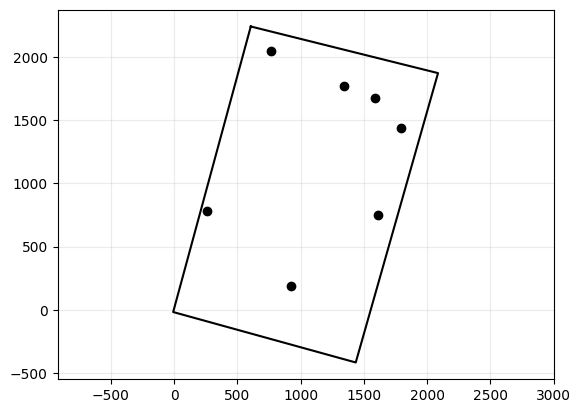

In [8]:
# random initial points
rng = np.random.default_rng(seed=42)
xturb, yturb = [], []

min_x, min_y, max_x, max_y = poly.bounds
while len(xturb) < Nturb:
    random_x = rng.uniform(min_x, max_x)
    random_y = rng.uniform(min_y, max_y)
    if Point(random_x, random_y).within(poly):
        xturb.append(random_x)
        yturb.append(random_y)

fig,ax = plt.subplots()
ax.plot(*poly.exterior.xy, 'k')
ax.plot(xturb, yturb, 'ko')
ax.axis('equal')
ax.grid(alpha=0.25)

In [9]:
layouts["coordinates"]["x"] = xturb
layouts["coordinates"]["y"] = yturb

prob.model.set_input_defaults("x_turbines", xturb, units="m")
prob.model.set_input_defaults("y_turbines", yturb, units="m")

/Users/equon/miniforge3/envs/ard-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'x_turbines' which override previously set defaults for ['auto', 'prom', 'units'].
/Users/equon/miniforge3/envs/ard-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'y_turbines' which override previously set defaults for ['auto', 'prom', 'units'].


In [10]:
if False:
    # visualize model
    om.n2(prob)

## run the model

In [11]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")

/Users/equon/miniforge3/envs/ard-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, TEST2_out/cases.sql, is being overwritten.




RESULTS:

{'AEP_val': 124.3977085916611,
 'BOS_val': 18.03508278433817,
 'CapEx_val': 30.939999999999998,
 'LCOE_val': 37.945483580569636,
 'OpEx_val': 1.0472000000000001,
 'coll_length': 4.336980651932086,
 'turbine_spacing': 0.2642590785359303}





In [12]:
print(prob.get_val("x_turbines", units="m"),
      prob.get_val("y_turbines", units="m"))

[1613.37865148 1790.64940932 1586.53657636  260.75054106  769.01962019
 1340.92109459  921.10421019] [ 749.63105986 1436.39166099 1672.04180123  780.20442401 2045.85834947
 1769.5399843   187.34218655]


In [13]:
print(prob.model.aepFLORIS.fmodel.wind_data.heterogeneous_map)
pp.pprint(prob.model.aepFLORIS.fmodel.core.flow_field.heterogeneous_inflow_config)

HeterogeneousMap with 2 dimensions using interpolation method "linear".
Speed multipliers are defined for 5 points and 3 wind conditions.

         0    1    2    3      4
0.0    1.0  1.0  1.0  1.0  1.125
157.5  1.0  1.0  1.0  1.0  1.125
270.0  1.0  1.0  1.0  1.0  1.125
{'interp_method': 'linear',
 'speed_multipliers': [[1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1

Now, we can optimize the same problem!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for LCOE.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [14]:
%%time

optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'x_turbines': array([1613.37865148, 1790.64940932, 1586.53657636,  260.75054106,
        769.01962019, 1340.92109459,  921.10421019]),
 'y_turbines': array([ 749.63105986, 1436.39166099, 1672.04180123,  780.20442401,
       2045.85834947, 1769.5399843 ,  187.34218655])}

Objectives
{'financese.lcoe': array([0.03794548])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'x_turbines': array([1613.37865148, 1790.64940932, 1586.53657636,  260.75054106,
        769.01962019, 1340.92109459,  921.10421019]),
 'y_turbines': array([ 749.63105986, 1436.39166099, 1672.04180123,  780.20442401,
       2045.85834947, 1769.5399843 ,  187.34218655])}

Objectives
{'financese.lcoe': array([0.03794545])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|2
------

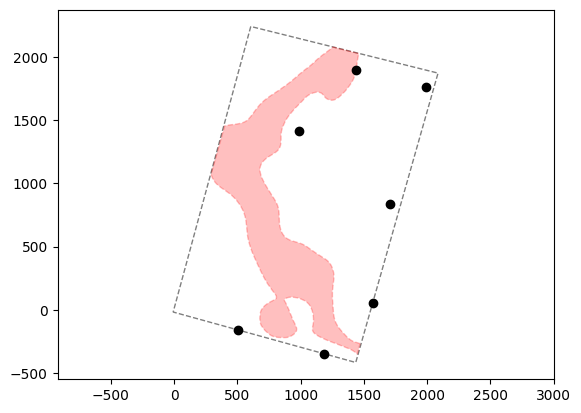

In [15]:
ax = plot_layout(
    prob,
    input_dict=input_dict,
    show_image=False,
    include_cable_routing=False,
)
plt.savefig(prob.get_outputs_dir() / 'layout.png')
plt.show()

In [16]:
print(prob.get_val("exclusions.exclusion_distances", units="km"))

[-3.13585341e-01 -6.69363077e-01 -5.65798917e-01 -1.84858036e-01
 -1.34706880e-01  1.56576293e-04 -1.07207920e-01]
